In [1]:
import torch

# Toy Supervised learning example: math
Image to modelling a problep in witch we have an input $X$ and we want to predict an output $y$:

$$y = model(X)$$

We want to a simple linear regression with two paramiter $w$ and $b$ as $model$, so our problem can be defined as:

$$y = w \cdot X + b$$

To complete our problem definition we need to define a loss function for example a mean squared error between the prediction and a manual labelled truth $Y$ (that in the case of 1 dimention like this is a simple squared error):

$$\mathcal{L}(Y, y) = \frac{\sum_{i=0}^1(y_i - Y_i)^2}{1} = (y - Y)^2$$

Now we can define that problem as a minimization problem as:

$$\min_{[w, b] \in \mathbb{R}^2} \mathcal{L}(Y, w \cdot X + b)$$

Where $X$ and $Y$ are costants, rispectivelly the input data and the truth. Instead $w$ and $b$ are the two params (weights or variables) that we want to find to solve this minimization problen.

We want to solve that problem with the Gradient Descend using Backpropagation algorithm. So we update the weight with a pas of learning rate with in the direction of $-gradient$:

![intuitive image of gradient descent with one weight](https://github.com/nicolalandro/empty/raw/main/gradient_descent.png)

# Toy Supervised learning example: code
Define our input (x) and output ground truth (y), that represent our dataset (our costants).

In [2]:
# input
x = torch.tensor([1.])
# supervised output
y = torch.tensor([5.])

Define our params (that need to be used to compute gradient)

In [3]:
w = torch.tensor([1.], requires_grad=True)
b = torch.tensor([5.], requires_grad=True)
params = [w, b]

We start from defining epochs and learing rate, 
for each epoch:
* get the prediction from the model
* calculate the loss
* clean the gradients
* calculate the gradients (backward)
* update the weight

In [4]:
EPOCHS = 2
LR = 0.1

for epoch in range(EPOCHS):
    # model
    pred = w * x + b

    # mse
    diff = y - pred
    loss = diff * diff

    # clean the gradient
    for p in params:
      if p.grad is not None:
          p.grad.detach_()
          p.grad.zero_()

    # compute gradients
    loss.backward()

    # update weights
    with torch.no_grad():
      for p in params:
        p_grad = p.grad
        p.add_(p_grad, alpha=-LR)

    print('EPOCH:', epoch, ', loss:', loss.item(), ', w:', w.item(), ', b:', b.item(), ', w grad:', w.grad.item(),
          ', b grad:', b.grad.item())

EPOCH: 0 , loss: 1.0 , w: 0.800000011920929 , b: 4.800000190734863 , w grad: 2.0 , b grad: 2.0
EPOCH: 1 , loss: 0.36000046133995056 , w: 0.6799999475479126 , b: 4.680000305175781 , w grad: 1.2000007629394531 , b grad: 1.2000007629394531


# Refactoring
This approach is very manual, we can extract the components in classes.

For the model part of the toy example we can create a class that extend $Module$ that add $w$ and $b$ as parameters and in the $forward$ do de computation

In [5]:
class SimpleModel(torch.nn.Module):
  def __init__(self):
    super(SimpleModel, self).__init__()
    self.w = torch.nn.Parameter(torch.tensor(1.))
    self.b = torch.nn.Parameter(torch.tensor(5.))
  
  def forward(self, x):
    return self.w * x + self.b

In [6]:
model = SimpleModel()

Also the loss function is equivalent to model so we extend the same class and do the computation in $forward$. In this case we do not have paramiters.

In [7]:
class Loss(torch.nn.Module):
  def __init__(self):
      super(Loss, self).__init__()

  def forward(self, y, pred):
    diff = y - pred
    loss = diff * diff
    return loss

In [8]:
criterion = Loss()

The optimizer extend $Optimizer$ and create a dictionary with all paramiter that get to the superclass. After in the $step$ method we can define the weight update. In particular we can use `@torch.no_grad()` for all method.

In [9]:
class SimpleOptimizer(torch.optim.Optimizer):
  def __init__(self, params, lr):
        defaults = dict(lr=lr, )
        super(SimpleOptimizer, self).__init__(params, defaults)

  @torch.no_grad()
  def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                p.add_(d_p, alpha=-group['lr'])

        return None

In [10]:
optimizer = SimpleOptimizer(model.parameters(), LR)

Now the loop is more simply.

In [11]:
for epoch in range(EPOCHS):
    pred = model(x)

    loss = criterion(y, pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('EPOCH:', epoch, ', loss:', loss.item())

EPOCH: 0 , loss: 1.0
EPOCH: 1 , loss: 0.36000046133995056


# PyTorch Way
In pythorch this code is just implemented and we can write more simply the following code.

In [12]:
model = torch.nn.Linear(1, 1) # his weight are random generated
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    #model.train()
    pred = model(x)

    loss = criterion(y, pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('EPOCH:', epoch, ', loss:', loss.item(), ', parmeters:', [ x.item() for x in list(model.parameters())])

EPOCH: 0 , loss: 22.224411010742188 , parmeters: [0.7959387302398682, 1.375495195388794]
EPOCH: 1 , loss: 8.000785827636719 , parmeters: [1.36165189743042, 1.9412083625793457]


Remember: 
* in a real case the $X$ examples are more than one
* in a real case all the $X$ example cannot go into RAM so we split it in batch and they are cicled into our Epoch for, so **an epoch end when all the batches are processed**
* pythorch take into account the batch size so the operation of Conv or Linear etc. are just ready to take as input a tensor with shape (batch, ...)
* test metrics are calculated each epoch by setting the model for validation by witching between `model.train()` and `model.eval` inside a `with torch.no_grad():` statement
* when implementing something try to not use for but try to use the torch vectorial cout to be more optimized on GPU
* if you youse numpy or other libraries to compute something remeber that this computation are not considered for the autograd (is as a costant for the backpropagation)

# Plots
Some plots are usefull to monitor the learing, the basics plots are:
* loss (y axis) during the epochs (x axes)
* test metrics (for example accuracy for calssification) during the epochs

We cannot plot in a real case the loss surface, but in this situation we can because we have $w$ and $b$ as paramiter so we can plot the $\mathcal{L}$ value on the Z of a 3D Plot.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


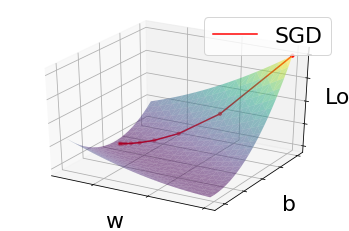

In [13]:
#@title Training Loss surface
import matplotlib.pyplot as plt
from numpy.ma import arange

def f(w, b):
    x = torch.tensor([1.])
    y = torch.tensor([5.])
    pred = w * x + b
    diff = y - pred
    loss = diff * diff
    return loss

def testOptimizer(optimizer, w1, w2, epochs=10, fu=f):
    points_x = []
    points_y = []
    points_z = []
    for epoch in range(epochs):
        loss = fu(w1, w2)
        # print(w1, w2, loss)

        points_x.append(w1.item())
        points_y.append(w2.item())
        points_z.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return points_x, points_y, points_z

w1 = torch.tensor([1.], requires_grad=True)
w2 = torch.tensor([5.], requires_grad=True)
sgd = torch.optim.SGD(params=[w1, w2], lr=LR)

fu = f
points_x, points_y, points_z = testOptimizer(sgd, w1, w2, epochs=10, fu=f)

plt.rcParams.update({'font.size': 22})
fig = plt.figure()
ax = fig.gca(projection='3d')

sgd_color = [1, 0, 0]
min_x, max_x, min_y, max_y = 4, 0, 4, 0
ax.scatter(points_x, points_y, points_z, c=sgd_color, s=10, antialiased=True)
ax.plot(points_x, points_y, points_z, c=sgd_color, antialiased=True, label='SGD')
min_x = min(min_x, min(points_x))
max_x = max(max_x, max(points_x))
min_y = min(min_y, min(points_y))
max_y = max(max_y, max(points_y))

x = []
y = []
z = []
pad = 0
resolution = 20
min_x = min_x - pad
min_y = min_y - pad
x_step = (max_x - min_x) / resolution
y_step = (max_y - min_y) / resolution
for w1_val in arange(min_x - x_step, max_x + x_step, x_step):
  for w2_val in arange(min_y - y_step, max_y + y_step, y_step):
    w1_tens = torch.tensor(w1_val)
    x.append(w1_tens.item())

    w2_tens = torch.tensor(w2_val)
    y.append(w2_tens.item())

    loss = fu(w1_tens, w2_tens)
    z.append(loss.item())

    # for color maps https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
ax.plot_trisurf(x, y, z, linewidth=0.2, alpha=0.5, cmap='viridis')
ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('Loss')
ax.legend()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

#fig.savefig('../../images/toy.pdf', bbox_inches='tight', pad_inches=0)

plt.show()